In [1]:
from pathlib import Path

import corner
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import jitr

In [2]:
import json

In [3]:
from jitr.optical_potentials import chuq, kduq, wlh

In [4]:
#  elastic reaction
target = (54, 26)
proton = (1, 1)
neutron = (1, 0)
projectile = proton

# for plotting differential xs
angles = np.linspace(0.1, np.pi, 100)

In [5]:
energies = [20.4]

In [6]:
with open("/home/beyerk/db/scatter_exp_data/KDUQCorpus/fe54/APower_p.json", "rb") as f:
    data = json.load(f)

In [7]:
def process(data_json):
    vals = np.array(data_json["values"])
    return vals[:,0], vals[:,1], vals[:,2]

In [8]:
data  = [process(d) for d in data['data'] if d['energy'] in energies]

In [9]:
core_solver = jitr.rmatrix.Solver(50)
reaction = jitr.reactions.ElasticReaction(
    target=target,
    projectile=projectile,
)

In [10]:
solvers = []
for Elab in energies:
    # get kinematics and parameters for this experiment
    kinematics = reaction.kinematics(Elab)

    a = jitr.utils.interaction_range(target[0]) * kinematics.k + np.pi * 3
    N = jitr.utils.suggested_basis_size(a)
    assert N < core_solver.kernel.quadrature.nbasis
    channel_radius_fm = a / kinematics.k

    solvers.append(
        jitr.xs.elastic.DifferentialWorkspace.build_from_system(
            reaction=reaction,
            kinematics=kinematics,
            channel_radius_fm=channel_radius_fm,
            solver=core_solver,
            lmax=50,
            angles=angles,
        )
    )

In [11]:
chuq_samples = chuq.get_samples_democratic(projectile)

In [12]:
chuq_pred_post_Ay = []

for solver in solvers:
    # get a differential xs for each parameter sample
    chuq_ay = np.zeros((len(angles), chuq.NUM_POSTERIOR_SAMPLES))

    for j, sample in enumerate(tqdm(chuq_samples)):
        coulomb_params, central_params, spin_orbit_params = chuq.calculate_params(
            projectile, target, solver.kinematics.Elab, *sample
        )

        xs = solver.xs(
            chuq.central_plus_coulomb,
            chuq.spin_orbit,
            (central_params, coulomb_params),
            spin_orbit_params,
        )
        chuq_ay[:, j] = xs.Ay

    chuq_pred_post_Ay.append(np.percentile(chuq_ay, [5, 95], axis=1))

100%|███████████████████████████████████████████████████████████████| 208/208 [00:08<00:00, 25.18it/s]


(-1.0, 10.0)

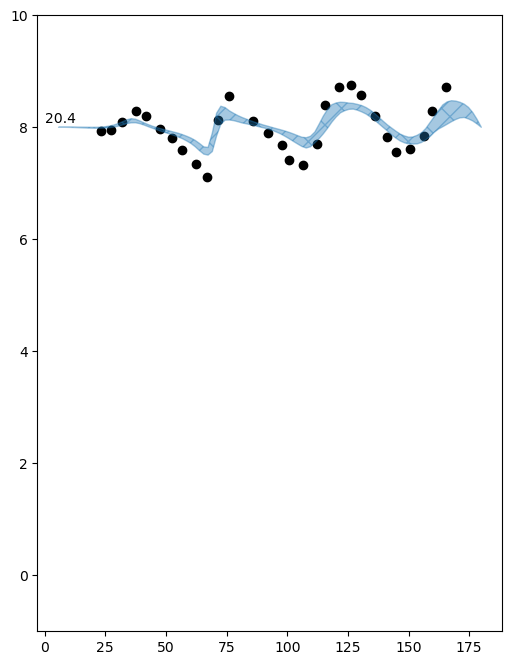

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8))
offsets =[8,6,4,2,0]
for i in range(len(solvers)):
    plt.text(0,1.01*offsets[i], f"{energies[i]}")
    if i < len(data):
        x,y,yerr = data[i]
        plt.errorbar(x,y+offsets[i],yerr, linestyle="none", marker='o', color='k')

    ax.fill_between(
        angles * 180 / np.pi,
        offsets[i] + chuq_pred_post_Ay[i][0],
        offsets[i] + chuq_pred_post_Ay[i][1],
        color="tab:blue",
        hatch="/\/",
        alpha=0.4,
        zorder=999
    )

plt.ylim([-1,10])